In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
state = {
    "game": {
        "id": "2eb74733-a69a-4abd-b074-44872ec7f492"
    },
    "turn": 1,
    "board": {
        "height": 19,
        "width": 19,
        "food": [
            {
                "x": 17,
                "y": 11
            }
        ],
        "snakes": [
            {
                "id": "gs_WXrcmMXyfyGx4Ff6bMffJQkR",
                "name": "ThomasDelteil / Randomino",
                "health": 99,
                "body": [
                    {
                        "x": 1,
                        "y": 0
                    },
                    {
                        "x": 1,
                        "y": 1
                    },
                    {
                        "x": 1,
                        "y": 1
                    }
                ]
            },
            {
                "id": "gs_v3Sm7xHjmQmWYrSRJywjGtGf",
                "name": "ThomasDelteil / Randomino",
                "health": 99,
                "body": [
                    {
                        "x": 18,
                        "y": 17
                    },
                    {
                        "x": 17,
                        "y": 17
                    },
                    {
                        "x": 17,
                        "y": 17
                    }
                ]
            },
            {
                "id": "gs_dSgtHdSDb3kjh8ykQK4p44w6",
                "name": "ThomasDelteil / Randomino",
                "health": 99,
                "body": [
                    {
                        "x": 0,
                        "y": 17
                    },
                    {
                        "x": 1,
                        "y": 17
                    },
                    {
                        "x": 1,
                        "y": 17
                    }
                ]
            },
            {
                "id": "gs_RQMqvpBYtHwRQbqkqrMM4k3F",
                "name": "ThomasDelteil / Randomino",
                "health": 99,
                "body": [
                    {
                        "x": 18,
                        "y": 1
                    },
                    {
                        "x": 17,
                        "y": 1
                    },
                    {
                        "x": 17,
                        "y": 1
                    }
                ]
            },
            {
                "id": "gs_yXKC7bJfY8BX74rpfWmJpVd3",
                "name": "ThomasDelteil / Randomino",
                "health": 99,
                "body": [
                    {
                        "x": 9,
                        "y": 2
                    },
                    {
                        "x": 9,
                        "y": 1
                    },
                    {
                        "x": 9,
                        "y": 1
                    }
                ]
            },
            {
                "id": "gs_FtPgTbfBGjMWBpw8fkvMx9vP",
                "name": "ThomasDelteil / Randomino",
                "health": 99,
                "body": [
                    {
                        "x": 17,
                        "y": 10
                    },
                    {
                        "x": 17,
                        "y": 9
                    },
                    {
                        "x": 17,
                        "y": 9
                    }
                ]
            },
            {
                "id": "gs_tmvVyMFPmPRBBTbx3MGGPYdD",
                "name": "ThomasDelteil / Randomino",
                "health": 99,
                "body": [
                    {
                        "x": 8,
                        "y": 17
                    },
                    {
                        "x": 9,
                        "y": 17
                    },
                    {
                        "x": 9,
                        "y": 17
                    }
                ]
            },
            {
                "id": "gs_S9CSv3wXCGGCyckXmTxp7pXJ",
                "name": "ThomasDelteil / Randomino",
                "health": 99,
                "body": [
                    {
                        "x": 1,
                        "y": 8
                    },
                    {
                        "x": 1,
                        "y": 9
                    },
                    {
                        "x": 1,
                        "y": 9
                    }
                ]
            }
        ]
    },
    "you": {
        "id": "gs_RQMqvpBYtHwRQbqkqrMM4k3F",
        "name": "ThomasDelteil / Randomino",
        "health": 99,
        "body": [
            {
                "x": 18,
                "y": 1
            },
            {
                "x": 17,
                "y": 1
            },
            {
                "x": 17,
                "y": 1
            }
        ]
    }
}

In [72]:
class BattleSnakeGame:
    
    FOOD_INDEX = 0
    YOU_INDEX = 1
    SNAKES_INDEX = 2
    
    def __init__(self, game_state):
        """
        Helper function to keep information about a game
        This is necessary because for layered representation
        We need to know how many snakes there were
        and which channels they were assigned to
        """
        
        self.game_id = game_state['game']['id']
        self.board_h = game_state['board']['height']
        self.board_w = game_state['board']['width']
        self.num_snakes = len(game_state['board']['snakes'])
        self.snake_to_ids = {game_state['you']['id']: BattleSnakeGame.YOU_INDEX}
        # Get the snake IDs
        k = 2
        for snake in game_state['board']['snakes']:
            if snake['id'] in self.snake_to_ids:
                continue
            self.snake_to_ids[snake['id']] = k
            k += 1
        

class ObservationToStateConverter:
    """
    Convert Battlesnake observation to the states that 
    were trained with
    
    """
    def __init__(self, style="layered", use_border=True):
        self.games = {}
        self.style = style
        self.use_border = use_border

    def _convert_to_state(self, game_state, game):
        
        # Get the border size
        border_size = 1 if self.use_border else 0
        
        # Get the style of state
        if self.style == 'layered':
            channels = game.num_snakes+1
        elif self.style == 'one_versus_all':
            channels = 3
        else:
            raise ValueError("Unkown style {}".format(self.style))
        
        # Create the base state matrix
        state = np.zeros((game.board_h + 2*border_size, game.board_w + 2*border_size, channels))
        
        # Add the borders
        if self.use_border:
            state = state - 1
            state[border_size:border_size+game.board_h, border_size:border_size+game.board_w,:] = 0
        
        # Put the food on the board
        for coord in game_state['board']['food']:
            state[coord['y']+border_size, coord['x']+border_size, BattleSnakeGame.FOOD_INDEX] = 1
            
        # Add the snakes
        for snake in game_state['board']['snakes']:
            first = True
            
            # Set the snakes channels to 2 if one vs all
            if self.style == 'one_versus_all':
                snake_channel = BattleSnakeGame.SNAKES_INDEX if game.snake_to_ids[snake['id']] != BattleSnakeGame.YOU_INDEX else BattleSnakeGame.YOU_INDEX
            else:
                snake_channel = game.snake_to_ids[snake['id']]
            for coord in snake['body']:
                state[coord['y']+border_size, coord['x']+border_size, snake_channel] = 2 if first else 1
                first = False
        
        return state
        
    def get_game_state(self, game_state):
        game_id = game_state['game']['id']
        if game_id not in self.games:
            self.games[game_id] = BattleSnakeGame(game_state)
            
        game = self.games[game_id]
        state = self._convert_to_state(game_state, game)
        return state

In [70]:
converter = ObservationToStateConverter(style='one_versus_all', use_border=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


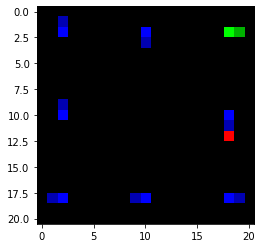

In [71]:
plt.imshow(converter.get_game_state(state)[:,:,:])